In [69]:
import pickle
from functools import partial
from pathlib import Path

import astropy.constants as c
import astropy.units as u
from dipsy.utils import Capturing
import disklab
import disklab.radmc3d
import dsharp_opac as do
import gofish as gf
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import image
from scipy.integrate import simpson
from scipy.interpolate import interp1d

import helper_functions as hf 
import helper_functions_old as hf_old

In [105]:
distance = 56 * u.pc
incl = 0
PA = 0

with open('options.pickle', 'rb') as fff:
    options_IMLup = pickle.load(fff)
with open('profile_ant.pickle', 'rb') as fff:
    profile_ant = pickle.load(fff)

The wavelenth for the RT image has to match exactly one of the wavelengths in the opacity dictionary. Take the closest wavelength to not have to recalculate the opacity.

In [71]:
lam_image = 15 * 1e-4  # cm

opac_dict = hf_old.read_opacs(Path('opacities/dustkappa_p30_chopped.npz'))
lam_opac = opac_dict['lam']
n_a = len(opac_dict['a'])
i = np.nonzero(lam_opac < lam_image)[0][-1]
lam_image = lam_opac[i]
print(lam_image)

0.001482021


In [72]:
radmc3d_exec = Path('~/bin/radmc3d').expanduser()

In [73]:
def interp_profile(profile_dict: dict, total_disk_mass: float) -> callable:
    """
    Interpolate a profile to use as gas surface density, normalized to a given total disk mass.
    
    Parameters
    ----------
    profile_dict: dict
        Dictionary containing the profile to use as surface density distribution. The keys must be named 'x' and 'y'.
    total_disk_mass: float
        Total disk mass.
        
    Returns
    -------
    float
        Normalized gas surface density function.
    """
    normalization_constant = total_disk_mass / simpson(2 * np.pi * profile_dict['x'] * profile_dict['y'], profile_dict['x'])
    
    # The profile cannot be <= 0, make sure that doesn't happen.
    y_profile = np.where(profile_dict['y'] > 0, profile_dict['y'], 0)
    # y_profile = np.copy(profile_dict['y'])
    # if np.min(y_profile) <= 0:
    #     y_profile += np.max(y_profile)

    normalization_constant = total_disk_mass / simpson(2 * np.pi * profile_dict['x'] * y_profile, profile_dict['x'])
    
    interp = interp1d(profile_dict['x'], y_profile, fill_value='extrapolate', kind='quadratic')
    print(normalization_constant)
    return lambda x: normalization_constant * interp(x)

15.631722263844297


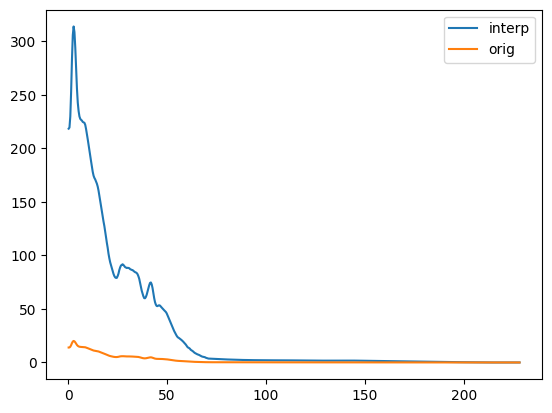

In [74]:
fname_profile = Path('./profile_bootstrap.pickle')

with open(fname_profile, 'rb') as f:
    profile_dict = pickle.load(f)

mdisk = 0.11 * c.M_sun.cgs.value
density_func = interp_profile(profile_dict, mdisk)

plt.plot(profile_dict['x'] / c.au.cgs.value, density_func(profile_dict['x']), label='interp')
plt.plot(profile_dict['x'] / c.au.cgs.value, profile_dict['y'], label='orig')
plt.legend()

In [75]:
options = {
    'mstar': 0.8 * c.M_sun.cgs.value,
    'lstar': 1 * c.L_sun.cgs.value,
    'tstar': 3810,
    'nr': 1000,
    'rin': np.min(profile_dict['x']),
    'rout': np.max(profile_dict['x']),
    'r_c': 30 * c.au.cgs.value,
    'alpha': 1e-3,
    'fname_opac': '/Users/franceschi/mysims/LESIA/opacities/dustkappa_p30_chopped.npz',
    'inc': 7,
    'PA': 0,
    'lam_image': lam_image,
    'distance': 56,
}

parameters = [
    0.5,  # grain size distribution, a**(4-x)
    3,  # max grain size radial distribution exponent
    0.087,  # max grain size radial distribution coefficient
]

r = np.arange(1, 200) * u.au

In [76]:
models_folder = Path('./models')
model_name = 'model_' + '_'.join(str(_param) for _param in parameters)
model_path = models_folder / model_name / model_name
model_path.parent.mkdir(parents=True, exist_ok=True)

In [77]:
if model_path.is_file():
    with open(model_path, 'rb') as fff:
        disk2d = pickle.load(fff)
else:
    disk2d = hf_old.make_disklab2d_model(
        parameters,
        options['mstar'],
        options['lstar'],
        options['tstar'],
        options['nr'],
        options['alpha'],
        options['rin'],
        options['rout'],
        options['r_c'],
        options['fname_opac'],
        density_func,
        show_plots=False
    )
    with open(model_path, 'wb') as fff:
        pickle.dump(disk2d, fff)

In [78]:
opac_dict = hf_old.read_opacs(options['fname_opac'])
lam_opac = opac_dict['lam']
n_a = len(opac_dict['a'])

radmcfolder = model_path.parents[0] / 'radmc_run/'
radmcfolder.mkdir(parents=True, exist_ok=True)
hf_old.write_radmc3d(disk2d, lam_opac, radmcfolder, show_plots=False)

# write the detailed scattering matrix files
for i_grain in range(n_a):
    do.write_radmc3d_scatmat_file(i_grain, opac_dict, f'{i_grain}', path=radmcfolder)

with open(Path(radmcfolder) / 'dustopac.inp', 'w') as f:
    disklab.radmc3d.write(f, '2               Format number of this file')
    disklab.radmc3d.write(f, '{}              Nr of dust species'.format(n_a))

    for i_grain in range(n_a):
        disklab.radmc3d.write(f, '============================================================================')
        disklab.radmc3d.write(f, '10               Way in which this dust species is read')
        disklab.radmc3d.write(f, '0               0=Thermal grain')
        disklab.radmc3d.write(f, '{}              Extension of name of dustscatmat_***.inp file'.format(i_grain))

    disklab.radmc3d.write(f, '----------------------------------------------------------------------------')

radmc_call = f"image incl {options['inc']} posang {options['PA'] - 90} npix 500 lambda {options['lam_image'] * 1e4} sizeau {2 * options['rout'] / c.au.cgs.value} setthreads 4"
disklab.radmc3d.radmc3d(
    radmc_call,
    path=radmcfolder,
    executable=str(radmc3d_exec)
)

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>                             VERSION 2.0
>>>   
>>>                   (c) 2008-2020 Cornelis Dullemond
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>                        the RADMC-3D forum:
>>>               http://radmc3d.ita.uni-heidelberg.de/phpbb/
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    ================================================================
>>>   
>>>    Number of processors:            8
>>>    Number of threads in use: 

In [79]:
fname_image_sim = radmcfolder / 'image.fits'
radmc_image_path = radmcfolder / 'image.out'
if radmc_image_path.is_file():
    im_mm_sim = image.readImage(str(radmc_image_path))
    radmc_image_path.replace(radmcfolder / 'image.out')
    im_mm_sim.writeFits(str(fname_image_sim), dpc=options['distance'], coord='11h01m51.9053285064s -34d42m17.033218380s')

Reading models/model_0.5_3_0.087/radmc_run/image.out


In [80]:
2 * options['rout'] / c.au.cgs.value

456.4601990580744

In [81]:
diam = 6.7 * u.m
lam_tel = 15 * u.micron
angle = (lam_tel / diam).decompose() * u.rad
angle * 56 * c.pc.to(u.au)

<Quantity 25.86006526 AU rad>

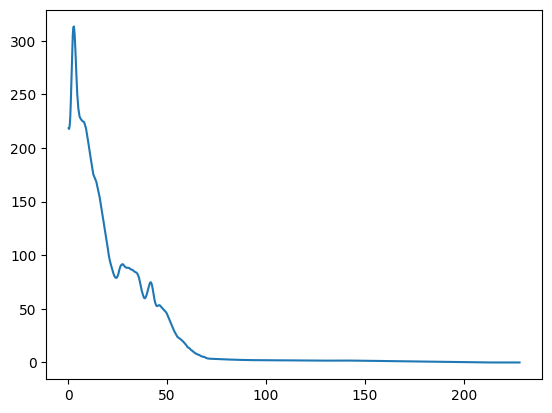

In [82]:
plt.plot(disk2d.disk.r / c.au.cgs.value, disk2d.disk.sigma)

In [83]:
model_path.parents[0] / 'radmc_run' / 'image.fits'

PosixPath('models/model_0.5_3_0.087/radmc_run/image.fits')

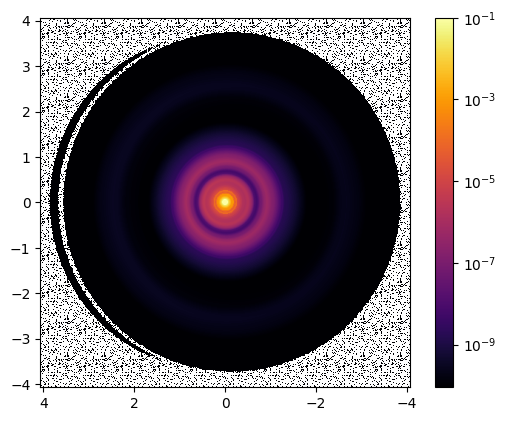

In [84]:
image_path = model_path.parents[0] / 'radmc_run' / 'image.fits'
imcube_model = gf.imagecube(image_path)

f, ax = plt.subplots()
norm = colors.LogNorm(1e-1, 1e-10)
im = ax.imshow(imcube_model.data, origin='lower', extent=imcube_model.extent, cmap='inferno', norm=norm)
cb = plt.colorbar(im)


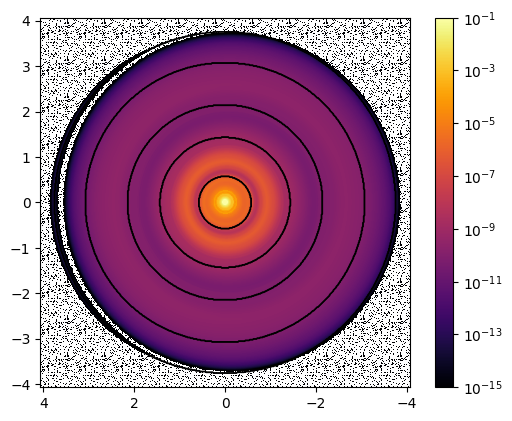

In [94]:
f, ax = plt.subplots()
norm = colors.LogNorm(1e-15, 1e-1)
im = ax.imshow(imcube_model.data, origin='lower', extent=imcube_model.extent, cmap='inferno', norm=norm)
cb = plt.colorbar(im)

rings_loc = (((np.array([32, 80, 120, 172, 210]) << u.au)/distance.to(u.au)).value * u.rad).to_value(u.arcsec)
for _ring in rings_loc:
    imcube_model.plot_mask(ax=ax, mask_alpha=0, r_max=_ring)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


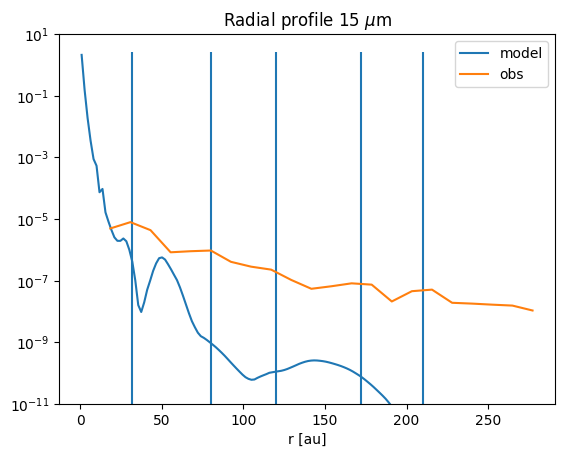

In [110]:
f, ax = plt.subplots()

rings_loc = np.array([32, 80, 120, 172, 210])
x_model, y_model, dy_model = imcube_model.radial_profile(inc=incl, PA=PA)
x_model = ((x_model * u.arcsec).to_value(u.rad, equivalencies=u.dimensionless_angles()) * distance).to(u.au)
ax.semilogy(x_model, y_model, label='model')
ax.vlines(rings_loc, 0.3 * y_model.min(), 1.2 * y_model.max())
ax.semilogy(profile_ant['A']['x'], profile_ant['A']['y'] * 1e-7, label='obs')
ax.set_xlabel('r [au]')
ax.set_title(r'Radial profile 15 $\mu$m')
# ax.set_xlim(0, 3)
ax.set_ylim(1e-11, 1e1)
ax.legend()